In [1]:
import sys
sys.path.append("..")

from eclipsoid import coeffs, compute_bounds, sT
from eclipsoid.numpy_src import compute_bounds as compute_bounds_python
from jax import config
import jax
config.update("jax_enable_x64", True)

from jaxoplanet.light_curves import limb_dark_light_curve
from jaxoplanet import light_curves, orbits
from jaxoplanet.orbits import TransitOrbit

import numpy as np
import jax.numpy as jnp
from scipy.integrate import quad
from scipy.special import binom, roots_legendre
import matplotlib.pyplot as plt
%matplotlib inline

# Jaxifying the oblate planet model

In this notebook, I will use the jaxified transit model and show how to compute an oblate planet model using vmap and jit

First, lets test on the standard jaxoplanet transit model and time it:

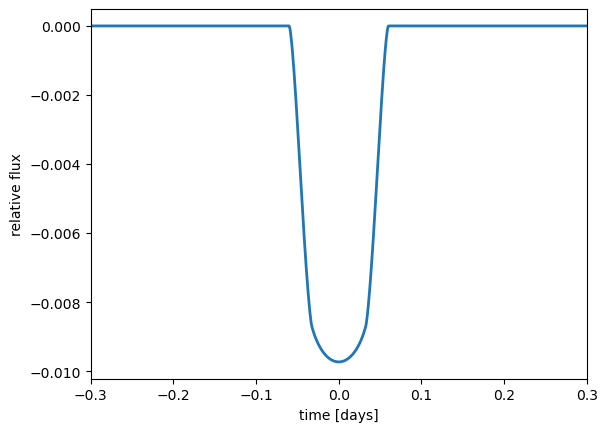

In [2]:
#Fiducial planet parameters:
from jaxoplanet.units import unit_registry as ureg
params = {'period':300.456,
          'radius':0.1,
          'u':jnp.array([0.3,0.2]),
          'b':0.7,
          'bo':0.8,
          'duration':0.12
}
# The light curve calculation requires an orbit

orbit = TransitOrbit(
    period=params['period'], time_transit=0, duration=params['duration'], impact_param=params['bo'], radius=params['radius']
)

# Compute a limb-darkened light curve using starry
t = jnp.linspace(-0.3, 0.3, 1000)

lc = jax.vmap(limb_dark_light_curve(orbit, params['u']))(t)

plt.plot(t, lc, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

In [12]:
def greens_basis_transform(u):
    
    """ Returns the star's flux in Green's basis
    given quadratic limb darkening coefficients"""
    assert u.shape[0]==2
    g = jnp.zeros(9)
    g = g.at[0].set(1-u[0]-2*u[1])
    g = g.at[2].set(u[0] + 2*u[1])
    g = g.at[4].set(u[1]/3)
    g = g.at[8].set(u[1])
    return g

In [17]:
xo, yo = orbit.relative_position(t)[0],orbit.relative_position(t)[1]

In [18]:
from jax import vmap
import jax
compute_bounds_vec = jax.jit(vmap(compute_bounds, in_axes=(None, 0,0,None)))

In [21]:
xis_jax, phis_jax = compute_bounds_vec(params['b'],xo.magnitude,yo.magnitude,params['radius'])

Now, let's time the computation of the integral bounds. It takes less than a millisecond to run, compared to half a second without vectorization and compilation!

In [ ]:
%% timeit
xis_jax, phis_jax = compute_bounds_vec(params['b'],xo,yo,params['radius'])

In [22]:
sT_vec = jax.jit(vmap(sT,in_axes=(0, 0, 0,0,None,0,0,None,None)), static_argnums=8)

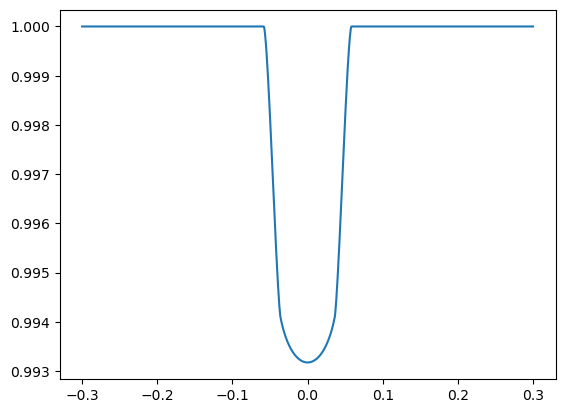

In [25]:
xis_jax, phis_jax = compute_bounds_vec(params['b'],xo.magnitude,yo.magnitude,params['radius'])
g = greens_basis_transform(params['u'])
ns = np.arange(len(g))
lcs = []
for n in ns:
    if g[n] != 0:
        lc = sT_vec(phis_jax[:,0],phis_jax[:,1], xis_jax[:,0],xis_jax[:,1], params['b'],xo.magnitude,yo.magnitude,params['radius'],n)
    else:
        lc = jnp.zeros(len(xo))
    lcs.append(lc)
    
    
lcs = jnp.array(lcs).T@g

plt.plot(t,lcs/lcs[0])

## Timing the oblate planet model:

For a light curve with 1000 points, it takes about 10ms to calculate a light curve!! That's only a factor of 3x slower than jaxoplanet!

In [26]:
%%timeit
g = greens_basis_transform(params['u'])
ns = np.arange(len(g))
lcs = []
for n in ns:
    if g[n] != 0:
        lc = sT_vec(phis_jax[:,0],phis_jax[:,1], xis_jax[:,0],xis_jax[:,1], params['b'],xo.magnitude,yo.magnitude,params['radius'],n)
    else:
        lc = jnp.zeros(len(xo))
    lcs.append(lc)
    
lcs = jax.block_until_ready(jnp.array(lcs).T@g)

15.6 ms ± 966 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
